# Code
***

# 1pm 07/05 - Different attempt

# Load
First, print the version of TensorFlow for clarity:

In [35]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.10.0


In [16]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import numpy as np
import time
from tensorflow.keras import mixed_precision

# Enable Mixed Precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Load Dataset
# **IMPORTANT**: This is not my student number My student number is G00383711. I sent you an email about the my student number causing issues with accuracy and performance. This happened with the VGG16 model. Using the seed below, both models perform well.
student_id_seed = 432121 

dataset_dir = 'E:\\GUI\\hagridset' 
image_size = (64, 64)
batch_size = 16
validation_split = 0.2

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=student_id_seed,
    image_size=image_size,
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=student_id_seed,
    image_size=image_size,
    batch_size=batch_size
)

# Save the class names
class_names = train_ds.class_names
num_classes = len(class_names)

# Further split validation set into val and test
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2 * val_batches) // 3)
val_ds = val_ds.skip((2 * val_batches) // 3)

# Cache and prefetch data for performance improvement
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 125912 files belonging to 18 classes.
Using 100730 files for training.
Found 125912 files belonging to 18 classes.
Using 25182 files for validation.


# Define and train cnn 

Epoch 1/10
6296/6296 [==============================] - 93s 15ms/step - loss: 2.3463 - accuracy: 0.2478 - val_loss: 1.5001 - val_accuracy: 0.5258
Epoch 2/10
6296/6296 [==============================] - 69s 11ms/step - loss: 1.4754 - accuracy: 0.5248 - val_loss: 1.1041 - val_accuracy: 0.6518
Epoch 3/10
6296/6296 [==============================] - 68s 11ms/step - loss: 1.2166 - accuracy: 0.6028 - val_loss: 1.0140 - val_accuracy: 0.6769
Epoch 4/10
6296/6296 [==============================] - 64s 10ms/step - loss: 1.0999 - accuracy: 0.6447 - val_loss: 0.9178 - val_accuracy: 0.7083
Epoch 5/10
6296/6296 [==============================] - 65s 10ms/step - loss: 1.0182 - accuracy: 0.6683 - val_loss: 0.8502 - val_accuracy: 0.7332
Epoch 6/10
6296/6296 [==============================] - 69s 11ms/step - loss: 0.9602 - accuracy: 0.6881 - val_loss: 0.8011 - val_accuracy: 0.7383
Epoch 7/10
6296/6296 [==============================] - 67s 11ms/step - loss: 0.9169 - accuracy: 0.7013 - val_loss: 0.7794 -

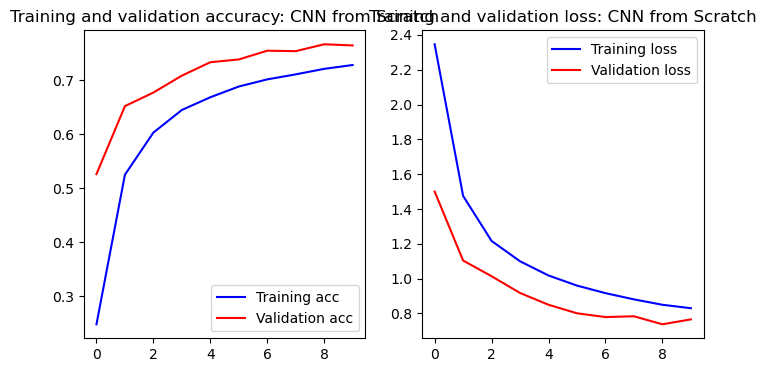

In [37]:
# Function to build a simple CNN model
def build_scratch_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')  # Explicitly set dtype
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train and evaluate the scratch model
input_shape = (64, 64, 3)

model_scratch = build_scratch_model(input_shape, num_classes)
history_scratch = model_scratch.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=batch_size
)

# Evaluate on test set
test_loss, test_acc = model_scratch.evaluate(test_ds)
print(f"Scratch Model Test Accuracy: {test_acc:.2f}")

# Function to visualize training history
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'Training and validation accuracy: {title}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss: {title}')
    plt.legend()

    plt.show()

# Plot history
plot_history(history_scratch, "CNN from Scratch")

# Transfer learning

Epoch 1/10
6296/6296 [==============================] - 133s 21ms/step - loss: 4.7022 - accuracy: 0.0962 - val_loss: 4.1545 - val_accuracy: 0.1256
Epoch 2/10
6296/6296 [==============================] - 131s 21ms/step - loss: 3.4657 - accuracy: 0.2339 - val_loss: 2.7031 - val_accuracy: 0.3126
Epoch 3/10
6296/6296 [==============================] - 131s 21ms/step - loss: 1.7630 - accuracy: 0.5871 - val_loss: 1.0888 - val_accuracy: 0.8033
Epoch 4/10
6296/6296 [==============================] - 132s 21ms/step - loss: 0.9845 - accuracy: 0.8315 - val_loss: 0.9267 - val_accuracy: 0.8441
Epoch 5/10
6296/6296 [==============================] - 131s 21ms/step - loss: 0.7886 - accuracy: 0.8786 - val_loss: 0.8361 - val_accuracy: 0.8651
Epoch 6/10
6296/6296 [==============================] - 128s 20ms/step - loss: 0.6464 - accuracy: 0.9114 - val_loss: 0.8042 - val_accuracy: 0.8706
Epoch 7/10
6296/6296 [==============================] - 121s 19ms/step - loss: 0.5329 - accuracy: 0.9340 - val_loss: 0

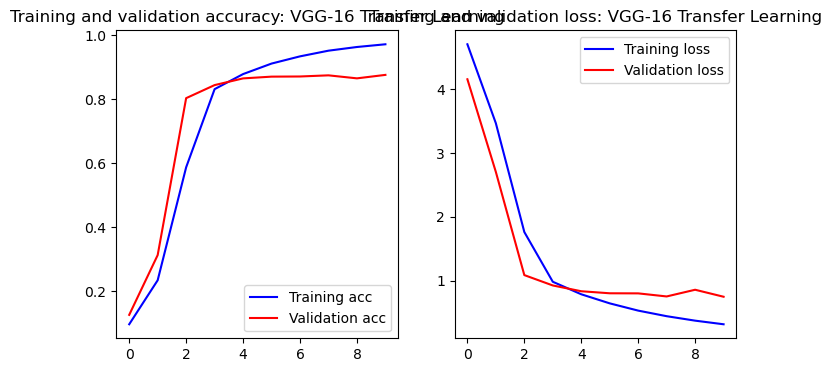

In [38]:
# Load VGG-16 Model with Transfer Learning and Fine-Tuning
def build_transfer_model(input_shape, num_classes):
    base_model = VGG16(
        weights='imagenet',
        input_shape=input_shape,
        include_top=False
    )

    # Unfreeze the last 8 layers for fine-tuning
    for layer in base_model.layers[:-8]:
        layer.trainable = False
    for layer in base_model.layers[-8:]:
        layer.trainable = True

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')  # Explicitly set dtype
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train and evaluate the transfer model
input_shape = (64, 64, 3)
model_transfer = build_transfer_model(input_shape, num_classes)

history_transfer = model_transfer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=batch_size
)

# Evaluate on test set
test_loss, test_acc = model_transfer.evaluate(test_ds)
print(f"Transfer Learning Model Test Accuracy: {test_acc:.2f}")

# Function to visualize training history
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'Training and validation accuracy: {title}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss: {title}')
    plt.legend()

    plt.show()

plot_history(history_transfer, "VGG-16 Transfer Learning")


# Model Iterations
***

## Greyscale CNN

First, we need to set the grayscale dataset

In [12]:
# Load grayscale dataset
train_ds_gray = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=student_id_seed,
    image_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale'
)
val_ds_gray = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=student_id_seed,
    image_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale'
)

# Save the class names
class_names = train_ds_gray.class_names
num_classes = len(class_names)

# Further split validation set into val and test
val_batches = tf.data.experimental.cardinality(val_ds_gray)
test_ds_gray = val_ds_gray.take((2 * val_batches) // 3)
val_ds_gray = val_ds_gray.skip((2 * val_batches) // 3)

# Cache and prefetch data for performance improvement
AUTOTUNE = tf.data.AUTOTUNE
train_ds_gray = train_ds_gray.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_gray = val_ds_gray.cache().prefetch(buffer_size=AUTOTUNE)
test_ds_gray = test_ds_gray.cache().prefetch(buffer_size=AUTOTUNE)


Found 125912 files belonging to 18 classes.
Using 100730 files for training.
Found 125912 files belonging to 18 classes.
Using 25182 files for validation.


In [14]:
# Function to visualize training history
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'Training and validation accuracy: {title}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss: {title}')
    plt.legend()

    plt.show()

Epoch 1/10
6296/6296 [==============================] - 74s 12ms/step - loss: 2.2246 - accuracy: 0.2813 - val_loss: 1.6250 - val_accuracy: 0.4743
Epoch 2/10
6296/6296 [==============================] - 66s 10ms/step - loss: 1.6723 - accuracy: 0.4561 - val_loss: 1.3618 - val_accuracy: 0.5666
Epoch 3/10
6296/6296 [==============================] - 69s 11ms/step - loss: 1.4461 - accuracy: 0.5261 - val_loss: 1.2410 - val_accuracy: 0.6066
Epoch 4/10
6296/6296 [==============================] - 65s 10ms/step - loss: 1.3069 - accuracy: 0.5720 - val_loss: 1.0702 - val_accuracy: 0.6590
Epoch 5/10
6296/6296 [==============================] - 69s 11ms/step - loss: 1.2037 - accuracy: 0.6072 - val_loss: 1.0120 - val_accuracy: 0.6722
Epoch 6/10
6296/6296 [==============================] - 66s 11ms/step - loss: 1.1322 - accuracy: 0.6290 - val_loss: 1.0050 - val_accuracy: 0.6805
Epoch 7/10
6296/6296 [==============================] - 68s 11ms/step - loss: 1.0746 - accuracy: 0.6462 - val_loss: 0.9482 -

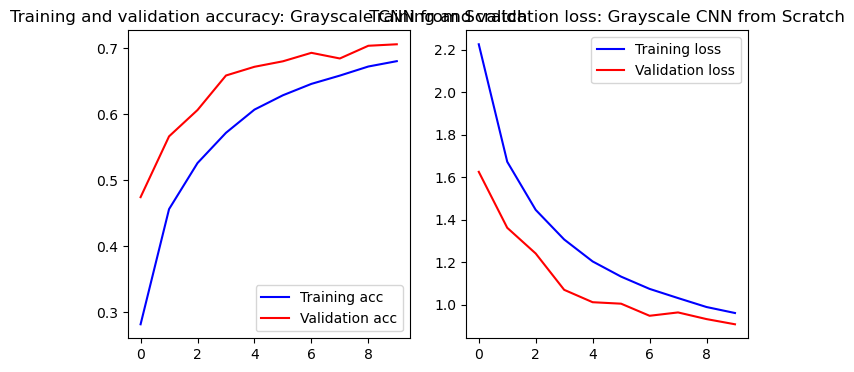

In [39]:
# Function to build a grayscale CNN model
def build_scratch_model_gray(input_shape, num_classes):
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')  # Explicitly set dtype
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train and evaluate the grayscale scratch model
input_shape_gray = (64, 64, 1)

model_scratch_gray = build_scratch_model_gray(input_shape_gray, num_classes)
history_scratch_gray = model_scratch_gray.fit(
    train_ds_gray,
    validation_data=val_ds_gray,
    epochs=10,
    batch_size=batch_size
)

# Evaluate on test set
test_loss, test_acc = model_scratch_gray.evaluate(test_ds_gray)
print(f"Grayscale Scratch Model Test Accuracy: {test_acc:.2f}")

# Plot history
plot_history(history_scratch_gray, "Grayscale CNN from Scratch")


## Greyscale VGG

Epoch 1/10
6296/6296 [==============================] - 134s 21ms/step - loss: 3.0671 - accuracy: 0.4321 - val_loss: 1.9786 - val_accuracy: 0.6999
Epoch 2/10
6296/6296 [==============================] - 127s 20ms/step - loss: 1.8196 - accuracy: 0.7279 - val_loss: 1.5730 - val_accuracy: 0.7796
Epoch 3/10
6296/6296 [==============================] - 128s 20ms/step - loss: 1.4918 - accuracy: 0.7962 - val_loss: 1.3954 - val_accuracy: 0.8086
Epoch 4/10
6296/6296 [==============================] - 142s 23ms/step - loss: 1.2740 - accuracy: 0.8367 - val_loss: 1.2820 - val_accuracy: 0.8235
Epoch 5/10
6296/6296 [==============================] - 158s 25ms/step - loss: 1.0956 - accuracy: 0.8662 - val_loss: 1.2258 - val_accuracy: 0.8232
Epoch 6/10
6296/6296 [==============================] - 144s 23ms/step - loss: 0.9419 - accuracy: 0.8912 - val_loss: 1.1298 - val_accuracy: 0.8351
Epoch 7/10
6296/6296 [==============================] - 124s 20ms/step - loss: 0.8095 - accuracy: 0.9116 - val_loss: 1

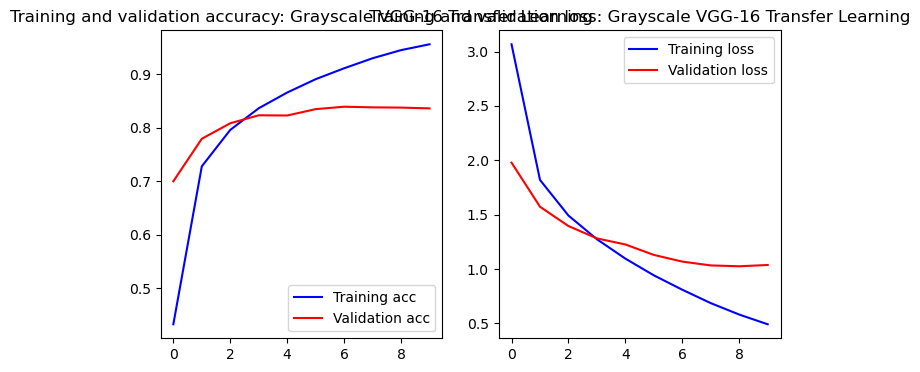

In [34]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Function to build a VGG16 model for grayscale images
def build_transfer_model_gray(input_shape, num_classes):
    base_model = VGG16(
        weights='imagenet',
        input_shape=(input_shape[0], input_shape[1], 3),  # Force 3-channel input
        include_top=False
    )

    # Unfreeze the last 8 layers for fine-tuning
    for layer in base_model.layers[:-8]:
        layer.trainable = False
    for layer in base_model.layers[-8:]:
        layer.trainable = True

    # Lambda layer to repeat the single grayscale channel
    def repeat_channel(x):
        return layers.Concatenate(axis=-1)([x, x, x])

    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Lambda(repeat_channel),
        base_model,
        layers.Flatten(),
        layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')  # Explicitly set dtype
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train and evaluate the grayscale VGG16 model
input_shape_gray = (64, 64, 1)

model_transfer_gray = build_transfer_model_gray(input_shape_gray, num_classes)
history_transfer_gray = model_transfer_gray.fit(
    train_ds_gray,
    validation_data=val_ds_gray,
    epochs=10,
    batch_size=batch_size
)

# Evaluate on test set
test_loss, test_acc = model_transfer_gray.evaluate(test_ds_gray)
print(f"Grayscale Transfer Learning Model Test Accuracy: {test_acc:.2f}")

# Function to visualize training history
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'Training and validation accuracy: {title}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss: {title}')
    plt.legend()

    plt.show()

# Plot history
plot_history(history_transfer_gray, "Grayscale VGG-16 Transfer Learning")


## Deeper CNN

Epoch 1/10
6296/6296 [==============================] - 799s 122ms/step - loss: 2.7914 - accuracy: 0.1215 - val_loss: 2.4583 - val_accuracy: 0.2184 - lr: 1.0000e-04
Epoch 2/10
6296/6296 [==============================] - 638s 101ms/step - loss: 2.2025 - accuracy: 0.2871 - val_loss: 1.8238 - val_accuracy: 0.4182 - lr: 1.0000e-04
Epoch 3/10
6296/6296 [==============================] - 633s 101ms/step - loss: 1.7216 - accuracy: 0.4420 - val_loss: 1.4556 - val_accuracy: 0.5221 - lr: 1.0000e-04
Epoch 4/10
6296/6296 [==============================] - 636s 101ms/step - loss: 1.4369 - accuracy: 0.5386 - val_loss: 1.4788 - val_accuracy: 0.5114 - lr: 1.0000e-04
Epoch 5/10
6296/6296 [==============================] - 647s 103ms/step - loss: 1.2447 - accuracy: 0.6009 - val_loss: 1.0792 - val_accuracy: 0.6536 - lr: 1.0000e-04
Epoch 6/10
6296/6296 [==============================] - 648s 103ms/step - loss: 1.1063 - accuracy: 0.6463 - val_loss: 0.9109 - val_accuracy: 0.7081 - lr: 1.0000e-04
Epoch 7/10

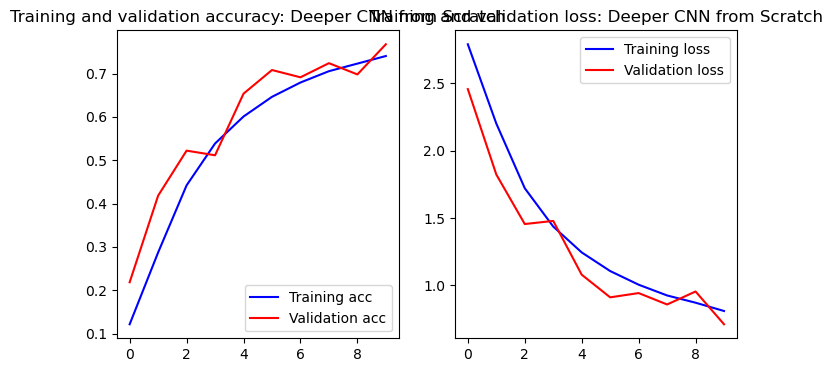

In [22]:
from tensorflow.keras import layers, models, callbacks

# Data augmentation layer
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1)
])

# Function to build a deeper CNN model with data augmentation and normalization
def build_deeper_scratch_model(input_shape, num_classes):
    model = models.Sequential([
        data_augmentation,
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')  # Explicitly set dtype
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Early Stopping and ReduceLROnPlateau Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-6
)

# Train and evaluate the deeper scratch model
input_shape_deeper = (64, 64, 3)

model_deeper_scratch = build_deeper_scratch_model(input_shape_deeper, num_classes)
history_deeper_scratch = model_deeper_scratch.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on test set
test_loss, test_acc = model_deeper_scratch.evaluate(test_ds)
print(f"Deeper Scratch Model Test Accuracy: {test_acc:.2f}")

# Function to visualize training history
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'Training and validation accuracy: {title}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss: {title}')
    plt.legend()

    plt.show()

# Plot history
plot_history(history_deeper_scratch, "Deeper CNN from Scratch")


## Data Augmentation & Dropout

CNN

In [23]:
import logging
import os
import tensorflow as tf

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

Epoch 1/10
6296/6296 [==============================] - 640s 101ms/step - loss: 2.8479 - accuracy: 0.0839 - val_loss: 2.7861 - val_accuracy: 0.1123 - lr: 0.0010
Epoch 2/10
6296/6296 [==============================] - 612s 97ms/step - loss: 2.7602 - accuracy: 0.1167 - val_loss: 2.6907 - val_accuracy: 0.1480 - lr: 0.0010
Epoch 3/10
6296/6296 [==============================] - 623s 99ms/step - loss: 2.6618 - accuracy: 0.1497 - val_loss: 2.4699 - val_accuracy: 0.2124 - lr: 0.0010
Epoch 4/10
6296/6296 [==============================] - 616s 98ms/step - loss: 2.5354 - accuracy: 0.1890 - val_loss: 2.3349 - val_accuracy: 0.2534 - lr: 0.0010
Epoch 5/10
6296/6296 [==============================] - 611s 97ms/step - loss: 2.4401 - accuracy: 0.2176 - val_loss: 2.2200 - val_accuracy: 0.2859 - lr: 0.0010
Epoch 6/10
6296/6296 [==============================] - 578s 92ms/step - loss: 2.3607 - accuracy: 0.2402 - val_loss: 2.1174 - val_accuracy: 0.3347 - lr: 0.0010
Epoch 7/10
6296/6296 [=================

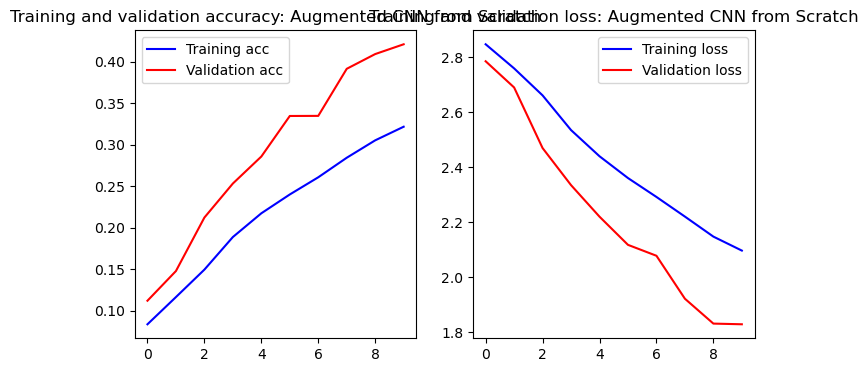

In [28]:
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

# Data augmentation layer
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1)
])

# Function to build a base CNN model with data augmentation
def build_augmented_scratch_model(input_shape, num_classes):
    model = models.Sequential([
        data_augmentation,
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')  # Explicitly set dtype
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Early Stopping and Reduce Learning Rate on Plateau
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-6
)

# Train and evaluate the augmented scratch model
input_shape_augmented = (64, 64, 3)
model_augmented_scratch = build_augmented_scratch_model(input_shape_augmented, num_classes)
history_augmented_scratch = model_augmented_scratch.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on test set
test_loss, test_acc = model_augmented_scratch.evaluate(test_ds)
print(f"Augmented Scratch Model Test Accuracy: {test_acc:.2f}")

# Function to visualize training history
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f"Training and validation accuracy: {title}")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f"Training and validation loss: {title}")
    plt.legend()

    plt.show()

# Plot training history
plot_history(history_augmented_scratch, "Augmented CNN from Scratch")


VGG

Epoch 1/10
6296/6296 [==============================] - 677s 106ms/step - loss: 3.5089 - accuracy: 0.2493 - val_loss: 2.1989 - val_accuracy: 0.5626 - lr: 1.0000e-05
Epoch 2/10
6296/6296 [==============================] - 665s 106ms/step - loss: 2.0675 - accuracy: 0.5811 - val_loss: 1.6448 - val_accuracy: 0.6973 - lr: 1.0000e-05
Epoch 3/10
6296/6296 [==============================] - 674s 107ms/step - loss: 1.7016 - accuracy: 0.6746 - val_loss: 1.5184 - val_accuracy: 0.7260 - lr: 1.0000e-05
Epoch 4/10
6296/6296 [==============================] - 666s 106ms/step - loss: 1.5042 - accuracy: 0.7209 - val_loss: 1.2936 - val_accuracy: 0.7726 - lr: 1.0000e-05
Epoch 5/10
6296/6296 [==============================] - 665s 106ms/step - loss: 1.3579 - accuracy: 0.7512 - val_loss: 1.2133 - val_accuracy: 0.7816 - lr: 1.0000e-05
Epoch 6/10
6296/6296 [==============================] - 665s 106ms/step - loss: 1.2376 - accuracy: 0.7732 - val_loss: 1.1185 - val_accuracy: 0.7964 - lr: 1.0000e-05
Epoch 7/10

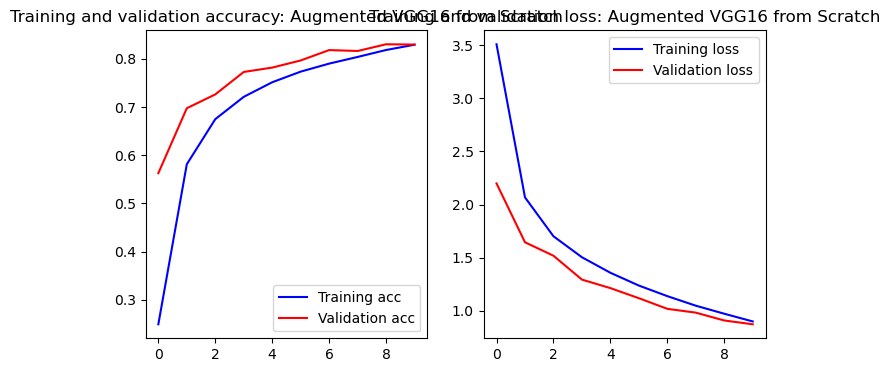

In [29]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

# Data augmentation layer
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1)
])

# Function to build a VGG16 transfer learning model with data augmentation
def build_augmented_vgg16_model(input_shape, num_classes):
    base_model = VGG16(
        weights='imagenet',
        input_shape=input_shape,
        include_top=False
    )
    for layer in base_model.layers[:-8]:
        layer.trainable = False
    for layer in base_model.layers[-8:]:
        layer.trainable = True

    model = models.Sequential([
        data_augmentation,
        layers.Rescaling(1./255, input_shape=input_shape),
        base_model,
        layers.Flatten(),
        layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')  # Explicitly set dtype
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Early Stopping and Reduce Learning Rate on Plateau
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-6
)

# Train and evaluate the augmented VGG16 model
input_shape_augmented = (64, 64, 3)

model_augmented_vgg16 = build_augmented_vgg16_model(input_shape_augmented, num_classes)
history_augmented_vgg16 = model_augmented_vgg16.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on test set
test_loss, test_acc = model_augmented_vgg16.evaluate(test_ds)
print(f"Augmented VGG16 Model Test Accuracy: {test_acc:.2f}")

# Function to visualize training history
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f"Training and validation accuracy: {title}")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f"Training and validation loss: {title}")
    plt.legend()

    plt.show()

# Plot training history
plot_history(history_augmented_vgg16, "Augmented VGG16 from Scratch")


# Comparison and Testing

1049/1049 [==============================] - 11s 10ms/step - loss: 0.8896 - accuracy: 0.8269
Scratch Model (Color) Test Accuracy: 0.76
Transfer Model (Color) Test Accuracy: 0.88
Grayscale Scratch Model Test Accuracy: 0.70
Grayscale Transfer Model Test Accuracy: 0.84
Deeper Scratch Model Test Accuracy: 0.77
Augmented Scratch Model Test Accuracy: 0.42
Augmented VGG16 Model Test Accuracy: 0.83
Inference Time - Scratch Model (Color): 4.64s
Inference Time - Transfer Model (Color): 9.45s
Inference Time - Grayscale Scratch Model: 5.18s
Inference Time - Grayscale Transfer Model: 10.18s
Inference Time - Deeper Scratch Model: 6.13s
Inference Time - Augmented Scratch Model: 5.24s
Inference Time - Augmented VGG16 Model: 10.67s


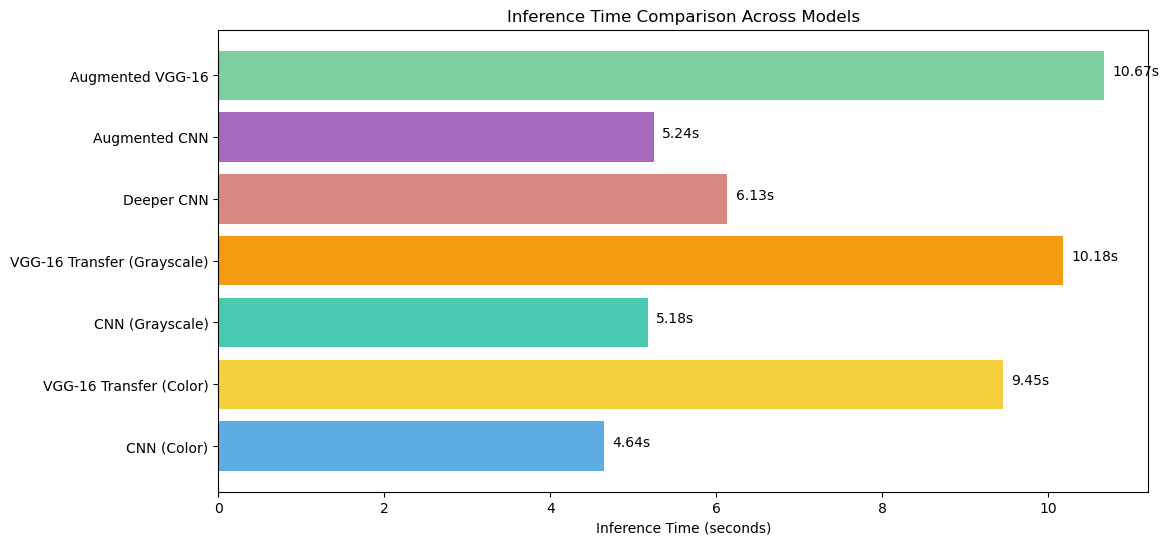

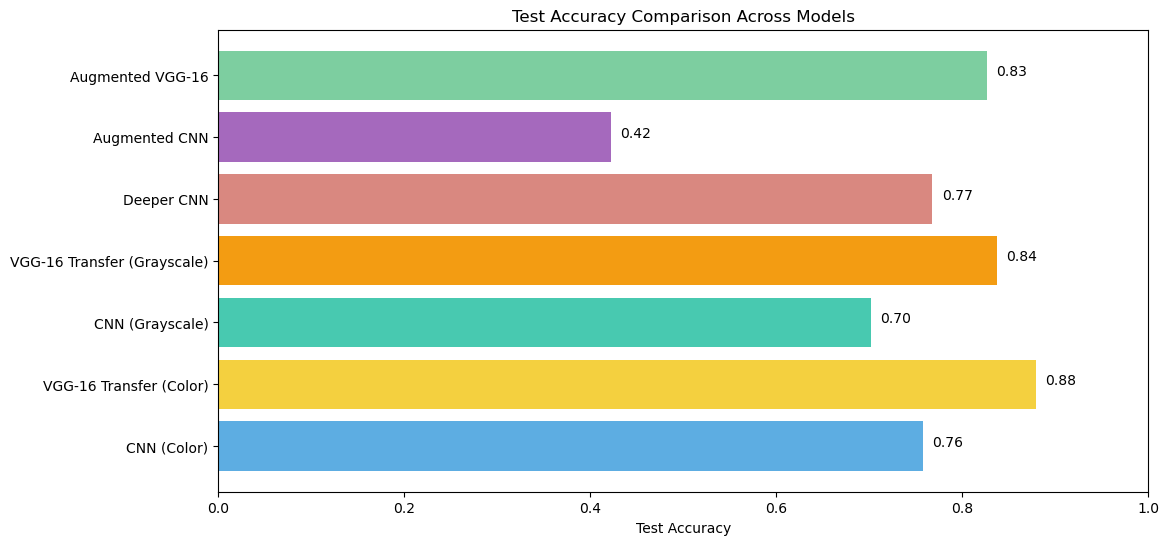

In [40]:
# Compare inference times
import time

def measure_inference_time(model, dataset):
    start_time = time.time()
    model.evaluate(dataset)
    elapsed_time = time.time() - start_time
    return elapsed_time

# Evaluate models and collect final accuracies
test_acc_scratch = model_scratch.evaluate(test_ds, verbose=0)[1]
test_acc_transfer = model_transfer.evaluate(test_ds, verbose=0)[1]
test_acc_scratch_gray = model_scratch_gray.evaluate(test_ds_gray, verbose=0)[1]
test_acc_transfer_gray = model_transfer_gray.evaluate(test_ds_gray, verbose=0)[1]
test_acc_deeper_scratch = model_deeper_scratch.evaluate(test_ds, verbose=0)[1]
test_acc_augmented_scratch = model_augmented_scratch.evaluate(test_ds, verbose=0)[1]
test_acc_augmented_vgg16 = model_augmented_vgg16.evaluate(test_ds, verbose=0)[1]

# Measure inference times
inference_time_scratch = measure_inference_time(model_scratch, test_ds)
inference_time_transfer = measure_inference_time(model_transfer, test_ds)
inference_time_scratch_gray = measure_inference_time(model_scratch_gray, test_ds_gray)
inference_time_transfer_gray = measure_inference_time(model_transfer_gray, test_ds_gray)
inference_time_deeper_scratch = measure_inference_time(model_deeper_scratch, test_ds)
inference_time_augmented_scratch = measure_inference_time(model_augmented_scratch, test_ds)
inference_time_augmented_vgg16 = measure_inference_time(model_augmented_vgg16, test_ds)

# Print accuracies and inference times
print(f"Scratch Model (Color) Test Accuracy: {test_acc_scratch:.2f}")
print(f"Transfer Model (Color) Test Accuracy: {test_acc_transfer:.2f}")
print(f"Grayscale Scratch Model Test Accuracy: {test_acc_scratch_gray:.2f}")
print(f"Grayscale Transfer Model Test Accuracy: {test_acc_transfer_gray:.2f}")
print(f"Deeper Scratch Model Test Accuracy: {test_acc_deeper_scratch:.2f}")
print(f"Augmented Scratch Model Test Accuracy: {test_acc_augmented_scratch:.2f}")
print(f"Augmented VGG16 Model Test Accuracy: {test_acc_augmented_vgg16:.2f}")

print(f"Inference Time - Scratch Model (Color): {inference_time_scratch:.2f}s")
print(f"Inference Time - Transfer Model (Color): {inference_time_transfer:.2f}s")
print(f"Inference Time - Grayscale Scratch Model: {inference_time_scratch_gray:.2f}s")
print(f"Inference Time - Grayscale Transfer Model: {inference_time_transfer_gray:.2f}s")
print(f"Inference Time - Deeper Scratch Model: {inference_time_deeper_scratch:.2f}s")
print(f"Inference Time - Augmented Scratch Model: {inference_time_augmented_scratch:.2f}s")
print(f"Inference Time - Augmented VGG16 Model: {inference_time_augmented_vgg16:.2f}s")

# Prepare data for visualization
model_names = [
    "CNN (Color)",
    "VGG-16 Transfer (Color)",
    "CNN (Grayscale)",
    "VGG-16 Transfer (Grayscale)",
    "Deeper CNN",
    "Augmented CNN",
    "Augmented VGG-16"
]

test_accuracies = [
    test_acc_scratch,
    test_acc_transfer,
    test_acc_scratch_gray,
    test_acc_transfer_gray,
    test_acc_deeper_scratch,
    test_acc_augmented_scratch,
    test_acc_augmented_vgg16
]
inference_times = [
    inference_time_scratch,
    inference_time_transfer,
    inference_time_scratch_gray,
    inference_time_transfer_gray,
    inference_time_deeper_scratch,
    inference_time_augmented_scratch,
    inference_time_augmented_vgg16
]

# Create a comparative bar chart for inference time
plt.figure(figsize=(12, 6))
plt.barh(model_names, inference_times, color=['#5DADE2', '#F4D03F', '#48C9B0', '#F39C12', '#D98880', '#A569BD', '#7DCEA0'])
plt.xlabel('Inference Time (seconds)')
plt.title('Inference Time Comparison Across Models')
for index, value in enumerate(inference_times):
    plt.text(value + 0.1, index, f"{value:.2f}s")
plt.show()

# Create a comparative bar chart for accuracy
plt.figure(figsize=(12, 6))
plt.barh(model_names, test_accuracies, color=['#5DADE2', '#F4D03F', '#48C9B0', '#F39C12', '#D98880', '#A569BD', '#7DCEA0'])
plt.xlabel('Test Accuracy')
plt.title('Test Accuracy Comparison Across Models')
plt.xlim(0, 1)
for index, value in enumerate(test_accuracies):
    plt.text(value + 0.01, index, f"{value:.2f}")
plt.show()

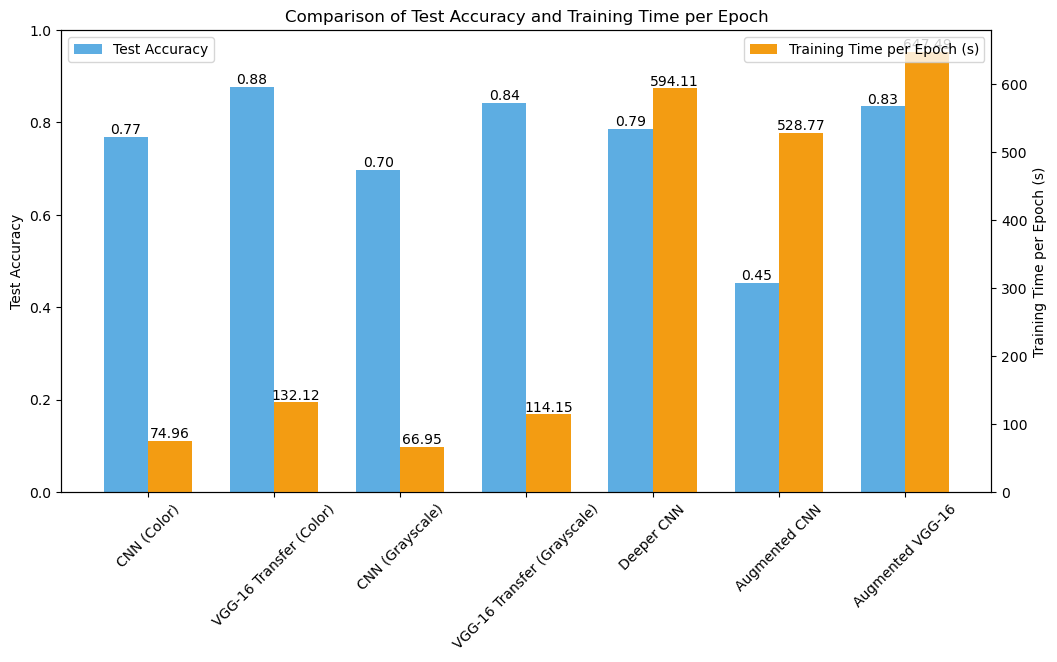

In [44]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import time

# Function to measure training time per epoch
def timed_fit(model, *args, **kwargs):
    start_time = time.time()
    history = model.fit(*args, **kwargs)
    elapsed_time = (time.time() - start_time) / len(history.epoch)
    return history, elapsed_time

# Measure test accuracy and calculate training time per epoch
results = []

# Re-train models for accurate timing
models_and_datasets = {
    "CNN (Color)": (model_scratch, (train_ds, val_ds, test_ds)),
    "VGG-16 Transfer (Color)": (model_transfer, (train_ds, val_ds, test_ds)),
    "CNN (Grayscale)": (model_scratch_gray, (train_ds_gray, val_ds_gray, test_ds_gray)),
    "VGG-16 Transfer (Grayscale)": (model_transfer_gray, (train_ds_gray, val_ds_gray, test_ds_gray)),
    "Deeper CNN": (model_deeper_scratch, (train_ds, val_ds, test_ds)),
    "Augmented CNN": (model_augmented_scratch, (train_ds, val_ds, test_ds)),
    "Augmented VGG-16": (model_augmented_vgg16, (train_ds, val_ds, test_ds))
}

for name, (model, datasets) in models_and_datasets.items():
    train_ds, val_ds, test_ds = datasets
    history, train_time_per_epoch = timed_fit(model, train_ds, validation_data=val_ds, epochs=1, batch_size=batch_size, verbose=0)
    test_acc = model.evaluate(test_ds, verbose=0)[1]
    results.append((name, test_acc, train_time_per_epoch))

# Extract results for plotting
model_names, test_accuracies, train_times_per_epoch = zip(*results)

# Create a grouped bar chart to compare accuracy and training time
x = np.arange(len(model_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax1 = plt.subplots(figsize=(12, 6))

bar1 = ax1.bar(x - width/2, test_accuracies, width, label='Test Accuracy', color='#5DADE2')
ax1.set_ylabel('Test Accuracy')
ax1.set_ylim(0, 1)
ax1.set_title('Comparison of Test Accuracy and Training Time per Epoch')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45)
ax1.legend(loc='upper left')

# Create secondary y-axis for training time
ax2 = ax1.twinx()
bar2 = ax2.bar(x + width/2, train_times_per_epoch, width, label='Training Time per Epoch (s)', color='#F39C12')
ax2.set_ylabel('Training Time per Epoch (s)')
ax2.legend(loc='upper right')

# Add labels to each bar
def add_labels(bars, axis):
    for bar in bars:
        height = bar.get_height()
        axis.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom')

add_labels(bar1, ax1)
add_labels(bar2, ax2)

plt.show()


In [10]:
# Final test using self-taken images
from tensorflow.keras.preprocessing import image

def predict_gesture(model, img_path, class_names):
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch dimension

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    return predicted_class

gesture_images = ['images/image_like.jpg',
                  'images/image_ok.jpg',
                  'images/image_stop.jpg',
                  'images/image_two.jpg']

for img_path in gesture_images:
    predicted_gesture = predict_gesture(model_transfer, img_path, class_names)
    print(f"Prediction for {img_path}: {predicted_gesture}")


1/1 [==============================] - 0s 421ms/step
Prediction for images/image_like.jpg: like
1/1 [==============================] - 0s 22ms/step
Prediction for images/image_ok.jpg: ok
1/1 [==============================] - 0s 23ms/step
Prediction for images/image_stop.jpg: stop
1/1 [==============================] - 0s 25ms/step
Prediction for images/image_two.jpg: two_up
